In [1]:
%pip install pandas_ta

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import yfinance as yf
import pandas as pd
import os
import pandas_ta as ta
import numpy as np
from sklearn.preprocessing import StandardScaler

The strategy here is identical to the one in final.py .

In [7]:
ticker="ITC.NS"      #Set any, with available data on yfinance, to test.

In [8]:
def data(ticker):
  df = yf.Ticker(ticker)
  df = df.history(period="max")
  df.index = pd.to_datetime(df.index)
  del df["Dividends"]
  del df["Stock Splits"]
  df = df.loc["2014-01-01":].copy()
  df["Target"] = (df["Close"] > df["Open"]).astype(int).shift(-1)   ##Binary target...tomorrow increase or decrease direction as an output to be decided by todays statistics
  # frequency = df['Target'].value_counts()
  # print(frequency)
  df.dropna(inplace=True)
  return df

In [9]:
# Calculating technical indicators using pandas_ta
def add_features(df):
    df['EMA_2'] = ta.ema(df['Close'], length=2)
    df['EMA_5'] = ta.ema(df['Close'], length=5)
    df['EMA_20'] = ta.ema(df['Close'], length=20)
    df['EMA_100'] = ta.ema(df['Close'], length=100)

    df['RSI_14'] = ta.rsi(df['Close'], length=14)
    macd = ta.macd(df['Close'])
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)
    df['OBV'] = ta.obv(df['Close'], df['Volume'])

    # Lagged features (kind of last few rows to predict the next row)
    for lag in range(1, 10):
    # lag-=1
        df[f'Close_t-{lag}'] = df['Close'].shift(lag)
        df[f'Open_t-{lag}'] = df['Open'].shift(lag)
        df[f'High_t-{lag}'] = df['High'].shift(lag)
        df[f'Low_t-{lag}'] = df['Low'].shift(lag)
        df[f'Volume_t-{lag}'] = df['Volume'].shift(lag)

    df = df.dropna()
    return df

In [10]:
df=data(ticker)
df_added=add_features(df)
df_added.head()

,Open,High,Low,Close,Volume,Target,EMA_2,EMA_5,EMA_20,EMA_100,...,Close_t-8,Open_t-8,High_t-8,Low_t-8,Volume_t-8,Close_t-9,Open_t-9,High_t-9,Low_t-9,Volume_t-9
Date,,,,,,,,,,,,,,,,,,,,,
2014-05-28 00:00:00+05:30,170.364329,170.463376,168.680498,169.794800,6250384,0.0,169.978517,170.363427,171.878508,166.846131,...,176.777771,183.141682,191.907525,174.573935,38847039.0,182.324524,181.086407,183.092148,180.343539,9562248.0
2014-05-29 00:00:00+05:30,170.859592,172.345328,168.581465,169.621475,15314620,0.0,169.740489,170.116110,171.663552,166.901089,...,167.442398,178.288273,178.783521,166.650007,24233856.0,176.777771,183.141682,191.907525,174.573935,38847039.0
2014-05-30 00:00:00+05:30,170.760564,170.760564,166.476696,169.250061,11046877,0.0,169.413537,169.827427,171.433696,166.947603,...,168.804337,169.373866,175.812057,165.684294,9241525.0,167.442398,178.288273,178.783521,166.650007,24233856.0
2014-06-02 00:00:00+05:30,169.373865,169.918638,166.105251,166.724304,10862329,1.0,167.620715,168.793053,170.985183,166.943181,...,169.200516,168.160505,169.819580,167.739548,10660248.0,168.804337,169.373866,175.812057,165.684294,9241525.0
2014-06-03 00:00:00+05:30,168.060494,169.169810,166.900766,168.110916,10778008,0.0,167.947516,168.565674,170.711443,166.966305,...,171.255783,169.869095,172.097698,168.556687,10527001.0,169.200516,168.160505,169.819580,167.739548,10660248.0


In [11]:
# Define lagged features and technical indicators
lagged_features = [f'Close_t-{i}' for i in range(1, 10)] + [f'Open_t-{i}' for i in range(1, 10)] + [f'Volume_t-{i}' for i in range(1, 10)]
featuresq = ['EMA_2', 'EMA_5','EMA_20','EMA_100', 'RSI_14', 'MACD_signal', 'ATR', 'OBV', 'Close', 'Volume']

# Combine all features
all_features = featuresq + lagged_features
# Feature normalization
scaler = StandardScaler()
df[all_features] = scaler.fit_transform(df[all_features])

# Preparing the features and target
X = df_added[all_features]
y = df_added['Target']

The strategy is simple. The model will be trained for the last 350 days of each day, and predict the direction of price for that day. It will buy accordingly at the opening price of the day and clear the position at the day when prediction is 0. It will always use atmost a certain percentage of cash to place the orders. An order log will be created and each order will be displayed. If cash is not enough to place an order, or clear a position, emergency account balance will be used accordingly and the trading process may get terminated.

In [12]:
#Defining the model, as per in final.py
from sklearn.ensemble import RandomForestClassifier
model3=RandomForestClassifier(n_estimators=500, min_samples_split=19, random_state=6,min_samples_leaf=1, max_features=25,n_jobs=-1)

In [9]:
print("Number of days in the data:", len(df))

Number of days in the data: 2602


In [13]:
#Setting any two indices, both between 351(350 days are required for prediction) and len(df)
#Trading will take place, as per model predictions, between the days defined by these indices.
start=600
end=900
df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d')
df[start:end]

,Open,High,Low,Close,Volume,Target,EMA_2,EMA_5,EMA_20,EMA_100,...,Close_t-8,Open_t-8,High_t-8,Low_t-8,Volume_t-8,Close_t-9,Open_t-9,High_t-9,Low_t-9,Volume_t-9
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-14,181.485052,183.088367,179.881736,-0.580297,-0.601173,1.0,-0.585519,-0.579877,-0.607730,-0.736969,...,-0.548957,-0.539692,186.450170,182.674617,-0.169043,-0.527610,-0.581498,187.329387,182.571160,-0.264277
2016-06-15,183.088366,186.191558,182.959062,-0.542215,-0.451465,0.0,-0.556764,-0.567490,-0.601618,-0.733193,...,-0.574218,-0.539692,186.113979,182.338438,-0.633717,-0.548584,-0.539289,186.450170,182.674617,-0.168912
2016-06-16,185.881258,185.881258,181.588503,-0.570548,-0.512526,1.0,-0.566088,-0.568712,-0.598826,-0.730093,...,-0.563744,-0.577545,184.614092,181.717788,-0.610682,-0.573875,-0.539289,186.113979,182.338438,-0.633502
2016-06-17,183.786558,186.553571,183.786558,-0.540388,-0.492830,0.0,-0.549067,-0.559435,-0.593385,-0.726414,...,-0.519692,-0.557234,188.131049,184.639957,-0.367354,-0.563389,-0.577184,184.614092,181.717788,-0.610472
2016-06-20,186.450119,186.708726,183.657253,-0.551356,-0.515240,1.0,-0.550713,-0.556920,-0.589522,-0.723041,...,-0.519384,-0.514149,188.777541,186.553585,-0.616783,-0.519283,-0.556850,188.131049,184.639957,-0.367188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-23,223.261136,224.914927,221.764858,-0.111573,-0.510561,0.0,-0.111788,-0.122033,-0.092789,-0.019437,...,-0.192610,-0.199304,216.291595,213.220283,-0.413417,-0.194148,-0.185856,216.882213,212.944627,-0.419776
2017-08-24,222.079823,223.261098,221.371062,-0.121779,-0.352724,1.0,-0.118258,-0.121575,-0.095080,-0.020958,...,-0.207620,-0.214768,216.134083,212.708379,-0.076778,-0.191800,-0.198522,216.291595,213.220283,-0.413242
2017-08-28,222.158599,222.867359,219.953536,-0.112501,-0.417094,0.0,-0.114222,-0.118166,-0.096255,-0.022253,...,-0.209965,-0.182903,216.094719,213.023406,-0.436514,-0.206829,-0.214003,216.134083,212.708379,-0.076664


In [14]:
def predict(model,i):
    model.fit(X.iloc[i-350:i], y.iloc[i-350:i])
    pred=model.predict(X.iloc[[i]])
    if(pred>0.5):
        return 1
    else:
        return 0


In [18]:
#Lets now set the cash available for trading, account balance, initial portfolio(same as initial cash)
account_balance=30000
cash=50000
initial_cash=cash
portfolio=cash
position=0
buy_price=0
predictions = []
log_file = 'trading_log.txt'
transaction_cost=0.001


In [19]:
with open(log_file, 'w') as file:
    file.write('Date,Time,Action,Price,Position,Portfolio Value,Cash,Account Balance\n')

In [20]:
from datetime import datetime, time

# Define market opening and closing times
market_opening_time = time(9, 30).strftime("%H:%M")  # 9:30 AM
market_closing_time = time(16, 0).strftime("%H:%M")  # 4:00 PM
order_time=market_opening_time

In [24]:
#Lets do the backtesting
for i in range(start,end):
  #Updating the account balance after each 100 days
  if((i-start)%100==0):
    account_balance+=10000
  pred=predict(model3,i)      #Can use your own model
  predictions.append(pred)
  date = df.index[i]
  open_price = df['Open'].iloc[i]
  value=open_price
  withdraw=0
  if (pred == 1):  # Buy signal
      amount_to_buy = (0.8*cash) // open_price
      req=amount_to_buy * open_price * (1 + transaction_cost)
      if (position == 0):  # No positions open
          # Buy
          if(cash<req):
            action = 'H0LD'
            withdraw=1
          else:
            cash-=req
            withdraw=0
            position = amount_to_buy
            value = open_price
            action = 'BUY'
      else:
          action = 'HOLD'
  else:  # Sell signal
      if position > 0:  # Position open
          # Sell
          cash += position * open_price * (1 + transaction_cost)
          value=open_price
          position = 0
          action = 'SELL'
      else:
          action = 'HOLD'

  order_time=market_opening_time
  # Print order details and portfolio value
  portfolio = cash + position * value
  print(f"Date: {date},Time: {order_time}, Action: {action}, Price: {value:.2f}, Position: {position:.2f}, Portfolio Value: ${portfolio:.2f}, Cash: ${cash:.2f}, Account Balance: ${account_balance:.2f}")

  # Log the order details
  with open(log_file, 'a') as file:
      file.write(f'{date},{order_time},{action},{value:.2f},{position:.2f},{portfolio:.2f},{cash:.2f},{account_balance:.2f}\n')

  # Calculate current portfolio value(at end of day)
  order_time=market_closing_time
  close_price = df['Close'].iloc[i]
  value=close_price
  if(portfolio+15000<0):       #Kind of stop loss
        # Sell
        cash += position * close_price * (1 + transaction_cost)
        position = 0
        action = 'SELL'
        portfolio = cash + position * value
        print(f"Date: {date},Time: {order_time}, Action: {action}, Price: {value:.2f}, Position: {position:.2f}, Portfolio Value: ${portfolio:.2f}, Cash: ${cash:.2f}, Account Balance: ${account_balance:.2f}")

        # Log the order details
        with open(log_file, 'a') as file:
          file.write(f'{date},{order_time},{action},{value:.2f},{position:.2f},{portfolio:.2f},{cash:.2f},{account_balance:.2f}\n')


  if(withdraw==1):
    req=amount_to_buy * open_price * (1 + transaction_cost)+10000
    if(account_balance<req+5000):
      continue
    else:
      cash+=req
      account_balance-=req


Date: 2016-06-14,Time: 09:30, Action: HOLD, Price: 181.49, Position: 0.00, Portfolio Value: $50000.00, Cash: $50000.00, Account Balance: $50000.00
Date: 2016-06-15,Time: 09:30, Action: HOLD, Price: 183.09, Position: 0.00, Portfolio Value: $50000.00, Cash: $50000.00, Account Balance: $50000.00
Date: 2016-06-16,Time: 09:30, Action: HOLD, Price: 185.88, Position: 0.00, Portfolio Value: $50000.00, Cash: $50000.00, Account Balance: $50000.00
Date: 2016-06-17,Time: 09:30, Action: HOLD, Price: 183.79, Position: 0.00, Portfolio Value: $50000.00, Cash: $50000.00, Account Balance: $50000.00
Date: 2016-06-20,Time: 09:30, Action: HOLD, Price: 186.45, Position: 0.00, Portfolio Value: $50000.00, Cash: $50000.00, Account Balance: $50000.00
Date: 2016-06-21,Time: 09:30, Action: HOLD, Price: 184.90, Position: 0.00, Portfolio Value: $50000.00, Cash: $50000.00, Account Balance: $50000.00
Date: 2016-06-22,Time: 09:30, Action: HOLD, Price: 184.10, Position: 0.00, Portfolio Value: $50000.00, Cash: $50000.00

Oh! How bad did it perform (or too good maybe :p ). Lets analyse.

In [25]:
#Lets load the log file 
result=pd.read_csv('trading_log.txt')
result.index=pd.to_datetime(result['Date']).dt.strftime('%Y-%m-%d')
result.drop(columns=['Date'],inplace=True)
result

,Time,Action,Price,Position,Portfolio Value,Cash,Account Balance
Date,,,,,,,
2016-06-14,09:30,HOLD,181.49,0.0,50000.00,50000.00,40000.0
2016-06-15,09:30,HOLD,183.09,0.0,50000.00,50000.00,40000.0
2016-06-16,09:30,HOLD,185.88,0.0,50000.00,50000.00,40000.0
2016-06-17,09:30,HOLD,183.79,0.0,50000.00,50000.00,40000.0
2016-06-20,09:30,HOLD,186.45,0.0,50000.00,50000.00,40000.0
...,...,...,...,...,...,...,...
2017-08-23,09:30,HOLD,223.26,0.0,57106.57,57106.57,70000.0
2017-08-24,09:30,HOLD,222.08,0.0,57106.57,57106.57,70000.0
2017-08-28,09:30,HOLD,222.16,0.0,57106.57,57106.57,70000.0


In [26]:
final_portfolio=result['Portfolio Value'].iloc[-1]
total_profit=final_portfolio-initial_cash
s=df.index[start]
e=df.index[end]
print(f"From {s} to {e}, the profit is :",total_profit )
pct_return=total_profit/initial_cash*100
print("Percentage return on initial cash :", pct_return)

From 2016-06-14 to 2017-08-31, the profit is : 7106.57
Percentage return on initial cash : 14.21314


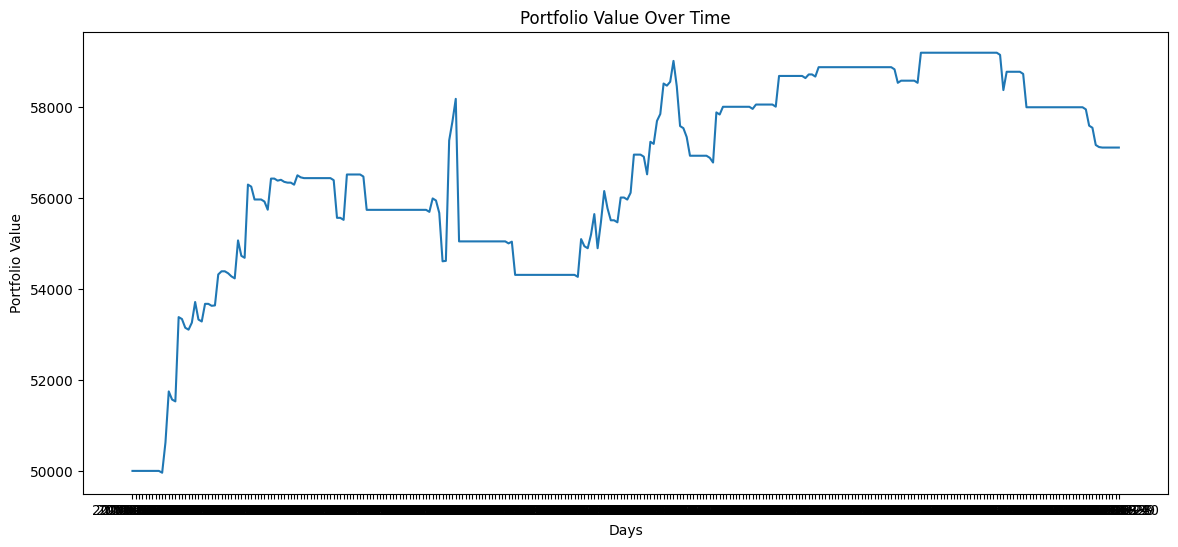

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(result['Portfolio Value'])
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.show()

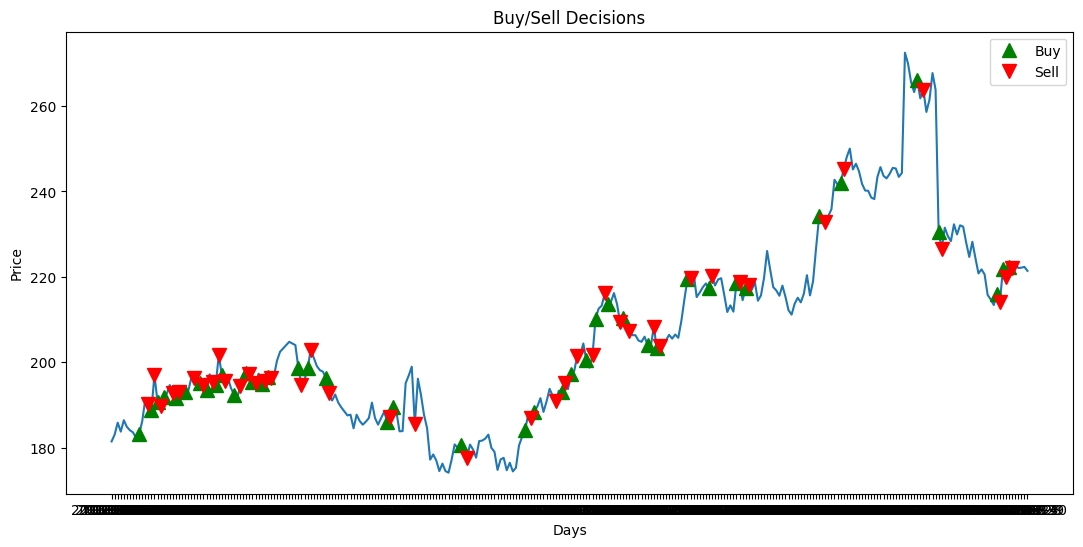

In [28]:
#Lets see in what pattern were the orders exactly placed
plt.figure(figsize=(13, 6))
plt.plot(df.iloc[start:end]['Open'])
#Lets plot the buy/sell action with symbols
buy_indices = result.index[result['Action'] == 'BUY']
sell_indices = result.index[result['Action'] == 'SELL']

plt.plot(buy_indices, result['Price'][buy_indices], '^', markersize=10, color='g', label='Buy') 
plt.plot(sell_indices, result['Price'][sell_indices], 'v', markersize=10, color='r', label='Sell') 
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Buy/Sell Decisions')
plt.legend()
plt.show()